In [ ]:
from  google.colab import files
uploaded = files.upload()

Saving salesweekly.csv to salesweekly.csv


In [ ]:
import pandas as pd

# Load the weekly dataset
df = pd.read_csv("salesweekly.csv")

# Ensure 'datum' is in datetime format and set as the index
df['datum'] = pd.to_datetime(df['datum'], format='%m/%d/%Y')
df.set_index('datum', inplace=True)
df.sort_index(inplace=True)

In [ ]:
# Create new features from the 'datum' index
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Week'] = df.index.isocalendar().week.astype(int)
df['Dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['Weekday Name'] = df.index.day_name()
df['month_name'] = df.index.month_name()

In [ ]:
# Select the target variable and features for the model
target = 'N02BE'
features = ['Year', 'Month', 'Week', 'Dayofweek', 'quarter', 'Weekday Name', 'month_name']

X = df[features]
y = df[target]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the categorical features
categorical_features = ['Weekday Name', 'month_name']
X_categorical = X[categorical_features]
X_numerical = X.drop(columns=categorical_features)

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X_categorical)
encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_features), index=X.index)
X_processed = pd.concat([X_numerical, encoded_df], axis=1)

In [ ]:
# Split the data into a training and testing set based on time
split_date = '2019-01-01'
X_train = X_processed.loc[X_processed.index < split_date]
y_train = y.loc[y.index < split_date]
X_test = X_processed.loc[X_processed.index >= split_date]
y_test = y.loc[y.index >= split_date]

In [ ]:
from  google.colab import files
uploaded = files.upload()

Saving salesweekly.csv to salesweekly.csv


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# --- Model Training ---
# Initialize the XGBoost Regressor with a small number of estimators
# We will manually control the stopping
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42)

# Manually implement early stopping
best_score = float('inf')
best_iteration = 0
patience = 50 # Number of rounds with no improvement before stopping

for i in range(1000):
    # Train the model for one more tree
    model.n_estimators = i + 1
    model.fit(X_train, y_train, verbose=False)

    # Make predictions and calculate the error
    predictions = model.predict(X_test)
    current_score = mean_absolute_error(y_test, predictions)

    # Check for improvement
    if current_score < best_score:
        best_score = current_score
        best_iteration = i
        # Reset patience counter
        patience_counter = 0
    else:
        # Increment patience counter if no improvement
        patience_counter += 1

    # Stop if patience runs out
    if patience_counter >= patience:
        print(f"Early stopping at iteration {i}. Best MAE: {best_score:.2f}")
        break

Early stopping at iteration 96. Best MAE: 39.46


In [ ]:
# Assuming you have already run the previous training code
from sklearn.metrics import mean_absolute_percentage_error

# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate and print the MAPE
mape = mean_absolute_percentage_error(y_test, predictions) * 100
print(f"Mean Absolute Percentage Error (MAPE) on the test set: {mape:.2f}%")

Mean Absolute Percentage Error (MAPE) on the test set: 23.33%


In [2]:
from  google.colab import files
uploaded = files.upload()

Saving salesweekly.csv to salesweekly.csv


In [3]:
import pandas as pd
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder

# --- 1. Data Preparation ---
# Load the weekly dataset
df = pd.read_csv("salesweekly.csv")

# Ensure 'datum' is in datetime format and set as the index
df['datum'] = pd.to_datetime(df['datum'], format='%m/%d/%Y')
df.set_index('datum', inplace=True)
df.sort_index(inplace=True)

# Create features from the date index
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Week'] = df.index.isocalendar().week.astype(int)
df['Dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['Weekday Name'] = df.index.day_name()
df['month_name'] = df.index.month_name()

# Define features and all drug categories as targets
features = ['Year', 'Month', 'Week', 'Dayofweek', 'quarter', 'Weekday Name', 'month_name']
targets = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

# Separate features (X) and all targets (y)
X = df[features]
y = df[targets]

# One-hot encode the categorical features
categorical_features = ['Weekday Name', 'month_name']
X_categorical = X[categorical_features]
X_numerical = X.drop(columns=categorical_features)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X_categorical)
encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_features), index=X.index)
X_processed = pd.concat([X_numerical, encoded_df], axis=1)

# Split the data into a training and testing set based on time
split_date = '2019-01-01'
X_train = X_processed.loc[X_processed.index < split_date]
y_train = y.loc[y.index < split_date]
X_test = X_processed.loc[X_processed.index >= split_date]
y_test = y.loc[y.index >= split_date]

# --- 2. Model Training ---
# Initialize the base XGBoost Regressor model
base_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42)

# Use MultiOutputRegressor to wrap the XGBoost model
multi_target_model = MultiOutputRegressor(base_model)

# Train the model on all drug categories
multi_target_model.fit(X_train, y_train)

# --- 3. Evaluation ---
# Make a single forecast for all drugs on the test set
predictions_all = multi_target_model.predict(X_test)

# Convert the predictions to a DataFrame for easier analysis
predictions_df = pd.DataFrame(predictions_all, columns=y_test.columns, index=y_test.index)

# Evaluate each drug's performance and store the results
results = {}
for drug in targets:
    mae = mean_absolute_error(y_test[drug], predictions_df[drug])
    mape = mean_absolute_percentage_error(y_test[drug], predictions_df[drug]) * 100
    results[drug] = {'MAE': mae, 'MAPE': mape}

results_df = pd.DataFrame(results).T
print("--- Multi-Output XGBoost Results (Weekly Data) ---")
print(results_df)

--- Multi-Output XGBoost Results (Weekly Data) ---
             MAE          MAPE
M01AB   8.597766  2.840409e+01
M01AE   8.270145  3.779285e+01
N02BA   5.572041  3.602665e+01
N02BE  46.859639  2.670617e+01
N05B   15.210925  3.032542e+01
N05C    3.379274  9.010425e+15
R03    25.276679  6.765249e+01
R06     9.848873  8.426907e+01


Long-Term Forecasting Code


In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder

# --- Data Preparation ---
df = pd.read_csv("salesweekly.csv")
df['datum'] = pd.to_datetime(df['datum'], format='%m/%d/%Y')
df.set_index('datum', inplace=True)
df.sort_index(inplace=True)
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Week'] = df.index.isocalendar().week.astype(int)
df['Dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['Weekday Name'] = df.index.day_name()
df['month_name'] = df.index.month_name()

# Define features and all drug categories as targets
features = ['Year', 'Month', 'Week', 'Dayofweek', 'quarter', 'Weekday Name', 'month_name']
drug_targets = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']
X = df[features]
y_all_drugs = df[drug_targets]

# One-hot encode the categorical features
categorical_features = ['Weekday Name', 'month_name']
X_categorical = X[categorical_features]
X_numerical = X.drop(columns=categorical_features)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X_categorical)
encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_features), index=X.index)
X_processed = pd.concat([X_numerical, encoded_df], axis=1)

# Split data for long-term forecast (2019-01-01 onwards)
split_date = '2019-01-01'
X_train_lt = X_processed.loc[X_processed.index < split_date]
y_train_lt = y_all_drugs.loc[y_all_drugs.index < split_date]
X_test_lt = X_processed.loc[X_processed.index >= split_date]
y_test_lt = y_all_drugs.loc[y_all_drugs.index >= split_date]

# --- Long-Term Forecasting Loop ---
print("--- Long-Term Forecasting Results ---")
for drug in drug_targets:
    y_train = y_train_lt[drug]
    y_test = y_test_lt[drug]

    # Initialize and train the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42)
    model.fit(X_train_lt, y_train)

    # Make a single forecast for the entire test set
    predictions_lt = model.predict(X_test_lt)

    # Evaluate
    mae_lt = mean_absolute_error(y_test, predictions_lt)
    mape_lt = mean_absolute_percentage_error(y_test, predictions_lt) * 100
    print(f"Drug {drug}: MAE = {mae_lt:.2f}, MAPE = {mape_lt:.2f}%")

--- Long-Term Forecasting Results ---
Drug M01AB: MAE = 8.60, MAPE = 28.40%
Drug M01AE: MAE = 8.27, MAPE = 37.79%
Drug N02BA: MAE = 5.57, MAPE = 36.03%
Drug N02BE: MAE = 46.86, MAPE = 26.71%
Drug N05B: MAE = 15.21, MAPE = 30.33%
Drug N05C: MAE = 3.38, MAPE = 9010424984690976.00%
Drug R03: MAE = 25.28, MAPE = 67.65%
Drug R06: MAE = 9.85, MAPE = 84.27%


In [5]:
# --- Data Preparation ---
# (Same data preparation from the long-term section above)

# --- Rolling Forecasting Loop ---
print("\n--- Rolling Forecasting Results ---")
for drug in drug_targets:
    print(f"Rolling forecast for {drug}...")

    # Get the data for the current drug
    y = df[drug]
    y_train_rolling = y.loc[y.index < split_date]
    y_test_rolling = y.loc[y.index >= split_date]

    predictions_rolling = []

    for i in range(len(X_test_lt)):
        # Define the current training and test sets for this iteration
        current_train_X = X_processed.loc[:X_test_lt.index[i-1]] if i > 0 else X_train_lt
        current_train_y = y.loc[:y.index[y.index == X_test_lt.index[i-1]][0]] if i > 0 else y_train_rolling
        current_test_X = X_test_lt.loc[[X_test_lt.index[i]]]

        # Retrain the model on the most up-to-date data
        rolling_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42)
        rolling_model.fit(current_train_X, current_train_y)

        # Make a single prediction
        prediction = rolling_model.predict(current_test_X)
        predictions_rolling.append(prediction[0])

    # Evaluate the rolling forecast
    mae_rolling = mean_absolute_error(y_test_rolling, predictions_rolling)
    mape_rolling = mean_absolute_percentage_error(y_test_rolling, predictions_rolling) * 100
    print(f"Drug {drug}: MAE = {mae_rolling:.2f}, MAPE = {mape_rolling:.2f}%")


--- Rolling Forecasting Results ---
Rolling forecast for M01AB...
Drug M01AB: MAE = 9.20, MAPE = 32.76%
Rolling forecast for M01AE...
Drug M01AE: MAE = 8.24, MAPE = 39.35%
Rolling forecast for N02BA...
Drug N02BA: MAE = 6.35, MAPE = 40.83%
Rolling forecast for N02BE...
Drug N02BE: MAE = 37.87, MAPE = 21.28%
Rolling forecast for N05B...
Drug N05B: MAE = 15.39, MAPE = 30.61%
Rolling forecast for N05C...
Drug N05C: MAE = 3.42, MAPE = 33821395644036464.00%
Rolling forecast for R03...
Drug R03: MAE = 22.67, MAPE = 56.65%
Rolling forecast for R06...
Drug R06: MAE = 8.14, MAPE = 80.45%


--- Long-Term Forecasting Results ---


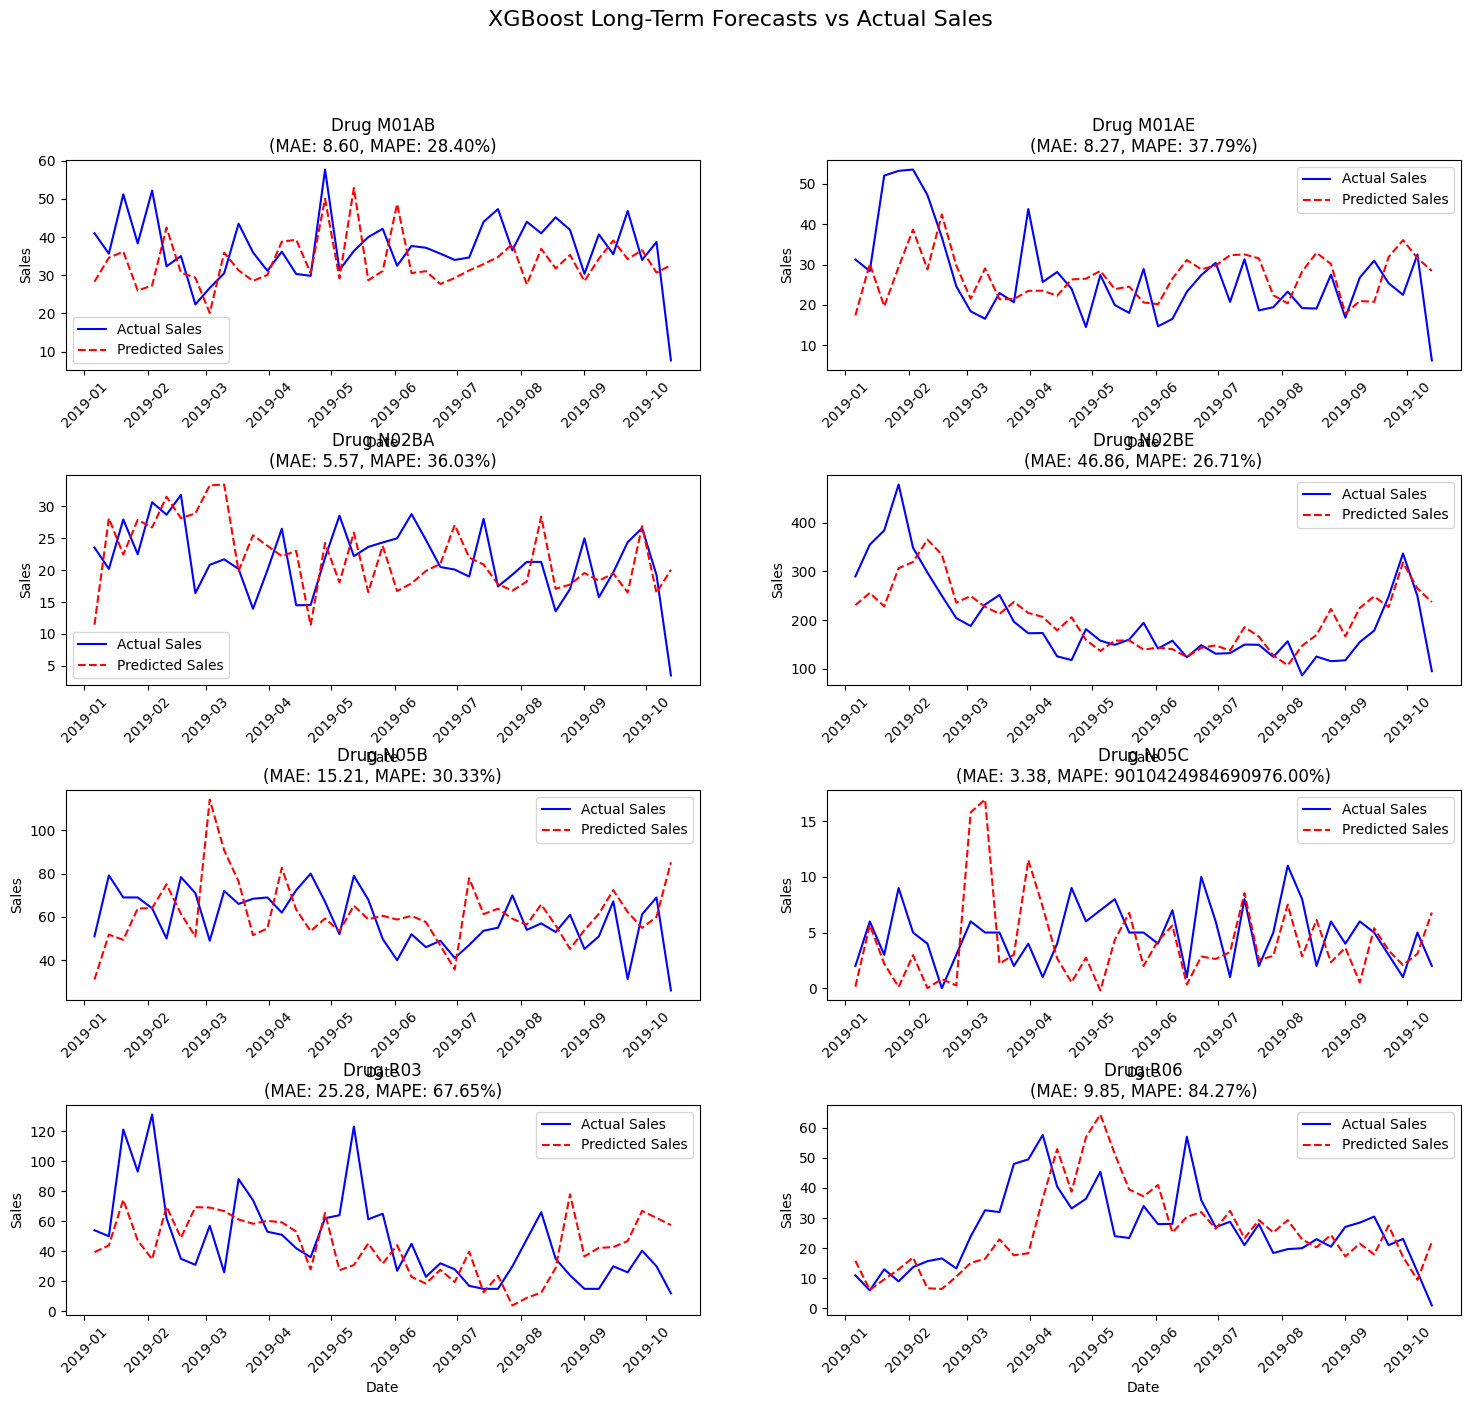

In [6]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Data Preparation ---
# Load the weekly dataset
df = pd.read_csv("salesweekly.csv")

# Ensure 'datum' is in datetime format and set as the index
df['datum'] = pd.to_datetime(df['datum'], format='%m/%d/%Y')
df.set_index('datum', inplace=True)
df.sort_index(inplace=True)

# Create features from the date index
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Week'] = df.index.isocalendar().week.astype(int)
df['Dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['Weekday Name'] = df.index.day_name()
df['month_name'] = df.index.month_name()

# Define features and all drug categories as targets
features = ['Year', 'Month', 'Week', 'Dayofweek', 'quarter', 'Weekday Name', 'month_name']
drug_targets = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

# Separate features (X) and all targets (y)
X = df[features]
y_all_drugs = df[drug_targets]

# One-hot encode the categorical features
categorical_features = ['Weekday Name', 'month_name']
X_categorical = X[categorical_features]
X_numerical = X.drop(columns=categorical_features)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X_categorical)
encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_features), index=X.index)
X_processed = pd.concat([X_numerical, encoded_df], axis=1)

# Split data for long-term forecast (2019-01-01 onwards)
split_date = '2019-01-01'
X_train_lt = X_processed.loc[X_processed.index < split_date]
y_train_lt = y_all_drugs.loc[y_all_drugs.index < split_date]
X_test_lt = X_processed.loc[X_processed.index >= split_date]
y_test_lt = y_all_drugs.loc[y_all_drugs.index >= split_date]

# --- Long-Term Forecasting Loop with Visualization ---
print("--- Long-Term Forecasting Results ---")
fig, axes = plt.subplots(4, 2, figsize=(18, 15))
fig.suptitle('XGBoost Long-Term Forecasts vs Actual Sales', fontsize=16)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, drug in enumerate(drug_targets):
    # Select the row and column for the current subplot
    row_index = i // 2
    col_index = i % 2
    ax = axes[row_index, col_index]

    y_train = y_train_lt[drug]
    y_test = y_test_lt[drug]

    # Initialize and train the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42)
    model.fit(X_train_lt, y_train)

    # Make a single forecast for the entire test set
    predictions_lt = model.predict(X_test_lt)

    # Evaluate
    mae_lt = mean_absolute_error(y_test, predictions_lt)
    mape_lt = mean_absolute_percentage_error(y_test, predictions_lt) * 100

    # Plot the results
    ax.plot(y_test.index, y_test.values, label="Actual Sales", color='blue')
    ax.plot(y_test.index, predictions_lt, label="Predicted Sales", color='red', linestyle='--')

    # Set plot title and labels
    ax.set_title(f"Drug {drug}\n(MAE: {mae_lt:.2f}, MAPE: {mape_lt:.2f}%)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)

plt.show()